In [5]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import imutils

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_curve, auc,
    matthews_corrcoef, ConfusionMatrixDisplay
)

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Input, Conv2D, concatenate, AveragePooling2D,
    BatchNormalization, Activation, MaxPooling2D,
    GlobalAveragePooling2D, Dense, Dropout
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.losses import CategoricalCrossentropy

# Preprocessing

In [6]:

# Path to dataset
dataset_path = '/kaggle/input/mri-images/'

# train and test folder paths
train_folder = os.path.join(dataset_path, 'Training')
test_folder = os.path.join(dataset_path, 'Testing')

train_images = []
train_labels = []
test_images = []
test_labels = []

img_size = (128, 128)

# Load training images and labels
print("Loading training dataset...")
for label in os.listdir(train_folder):
    class_folder = os.path.join(train_folder, label)
    if os.path.isdir(class_folder):
        print(f"Loading images from: {label}...")
        for file in tqdm(os.listdir(class_folder), desc=f"Processing {label}"):
            if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                file_path = os.path.join(class_folder, file)
                img = cv2.imread(file_path)
                if img is not None:
                    img = cv2.resize(img, img_size) # Resize to fixed dimensions
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # Convert BGR to RGB
                    img = cv2.bilateralFilter(img, d=9, sigmaColor=75, sigmaSpace=75)
                    train_images.append(img)
                    train_labels.append(label)
                else:
                    print(f" Failed to load: {file_path}")

# Load testing images and labels
print("\nLoading testing dataset...")
for label in os.listdir(test_folder):
    class_folder = os.path.join(test_folder, label)
    if os.path.isdir(class_folder):
        print(f"Loading images from: {label}...")
        for file in tqdm(os.listdir(class_folder), desc=f"Processing {label}"):
            if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                file_path = os.path.join(class_folder, file)
                img = cv2.imread(file_path)
                if img is not None:
                    img = cv2.resize(img, img_size) # Resize to fixed dimensions
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # Convert BGR to RGB
                    img = cv2.bilateralFilter(img, d=9, sigmaColor=75, sigmaSpace=75)
                    test_images.append(img)
                    test_labels.append(label)
                else:
                    print(f" Failed to load: {file_path}") 

Loading training dataset...
Loading images from: pituitary...


Processing pituitary: 100%|██████████| 1457/1457 [00:17<00:00, 81.12it/s]


Loading images from: notumor...


Processing notumor: 100%|██████████| 1595/1595 [00:16<00:00, 94.50it/s] 


Loading images from: meningioma...


Processing meningioma: 100%|██████████| 1339/1339 [00:14<00:00, 94.02it/s]


Loading images from: glioma...


Processing glioma: 100%|██████████| 1321/1321 [00:14<00:00, 91.36it/s]



Loading testing dataset...
Loading images from: pituitary...


Processing pituitary: 100%|██████████| 300/300 [00:03<00:00, 83.29it/s]


Loading images from: notumor...


Processing notumor: 100%|██████████| 405/405 [00:04<00:00, 99.46it/s] 


Loading images from: meningioma...


Processing meningioma: 100%|██████████| 306/306 [00:03<00:00, 88.89it/s]


Loading images from: glioma...


Processing glioma: 100%|██████████| 300/300 [00:03<00:00, 86.88it/s]


In [7]:
# Convert lists to NumPy arrays
train_images = np.array(train_images, dtype=np.uint8)
train_labels = np.array(train_labels)
test_images = np.array(test_images, dtype=np.uint8) 
test_labels = np.array(test_labels)

In [8]:
# Print dataset statistics
print(f"\nTrain: Loaded {len(train_images)} images with labels: {np.unique(train_labels)}")
print(f"Test: Loaded {len(test_images)} images with labels: {np.unique(test_labels)}")


Train: Loaded 5712 images with labels: ['glioma' 'meningioma' 'notumor' 'pituitary']
Test: Loaded 1311 images with labels: ['glioma' 'meningioma' 'notumor' 'pituitary']


In [9]:
print("Train images shape:", train_images.shape)
print("Train labels shape:", train_labels.shape)
print("Test images shape:", test_images.shape)
print("Test labels shape:", test_labels.shape)

Train images shape: (5712, 128, 128, 3)
Train labels shape: (5712,)
Test images shape: (1311, 128, 128, 3)
Test labels shape: (1311,)


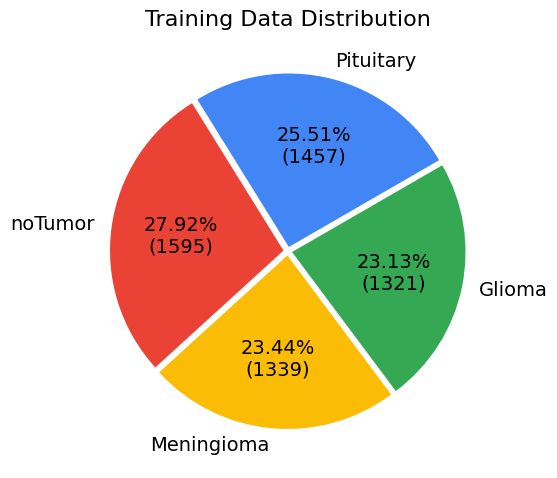

In [10]:
plt.figure(figsize=(10,5))
colors = ['#4285f4', '#ea4335', '#fbbc05', '#34a853']
plt.rcParams.update({'font.size': 14})

# Class labels and counts
class_names = ['Pituitary','noTumor', 'Meningioma', 'Glioma']
class_keys = ['pituitary', 'notumor', 'meningioma', 'glioma']
class_counts = [len([x for x in train_labels if x==k]) for k in class_keys]

# Custom autopct function to show percentage + count
def autopct_format(pct, allvals):
    count = int(round(pct * sum(allvals) / 100.0))
    return '{:.2f}%\n({:d})'.format(pct, count)

plt.pie(class_counts,
        labels=class_names,
        colors=colors,
        autopct=lambda pct: autopct_format(pct, class_counts),
        explode=(0.025, 0.025, 0.025, 0.025),
        startangle=30);

plt.title("Training Data Distribution", fontsize=16)
plt.tight_layout()
plt.show()


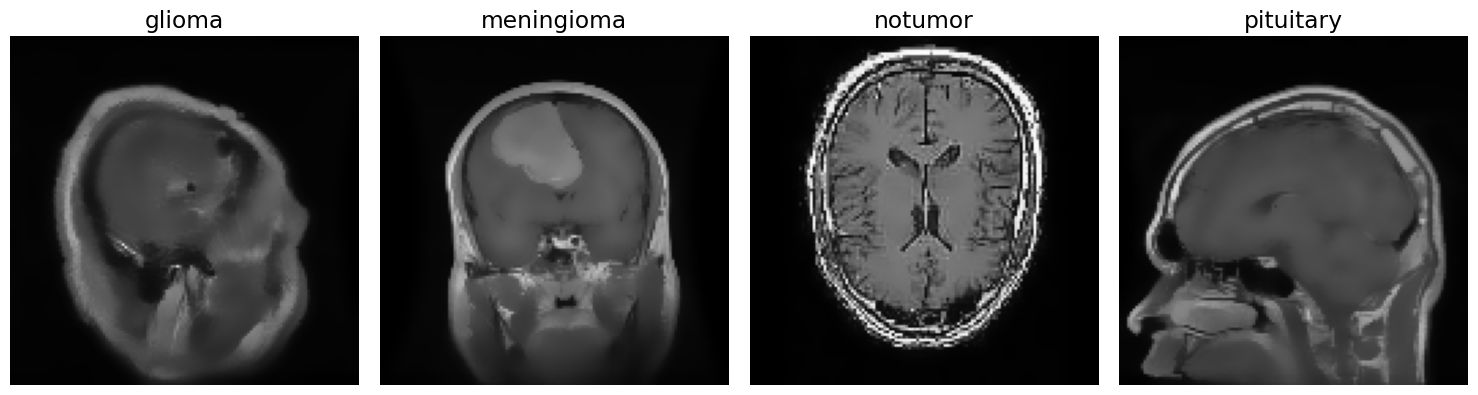

In [11]:

# Get the unique labels
unique_labels = np.unique(train_labels)

# Create subplots (one column per unique label)
fig, axs = plt.subplots(1, len(unique_labels), figsize=(15, 5))

# Loop over each label, find the first image for that label, and display it
for ax, label in zip(axs, unique_labels):
    # Get the index of the first image for the current label
    idx = np.where(train_labels == label)[0][0]
    ax.imshow(train_images[idx])
    ax.set_title(label)
    ax.axis('off')

plt.tight_layout()
plt.show()


In [12]:

# augmentation parameters
datagen = ImageDataGenerator(
    rotation_range=10,          # rotate images by up to 10 degrees
    width_shift_range=0.1,      # shift images horizontally by up to 10%
    height_shift_range=0.1,     # shift images vertically by up to 10%
    zoom_range=0.1,             # zoom in/out by up to 10%
    horizontal_flip=True,       # randomly flip images horizontally
)

# Number of augmented copies per original image
num_augmented = 2

augmented_images = []
augmented_labels = []

# Iterate over each image and generate augmented versions
for i in tqdm(range(len(train_images)), desc="Augmenting images"):
    img = train_images[i]
    label = train_labels[i]
    # Expand dimensions to create a batch of 1 image
    img_expanded = np.expand_dims(img, axis=0)
    # Create an iterator for augmented images
    aug_iter = datagen.flow(img_expanded, batch_size=1, shuffle=False)

    # Generate a fixed number of augmented images for the current image
    for _ in range(num_augmented):
        aug_img = next(aug_iter)[0]
        augmented_images.append(aug_img)
        augmented_labels.append(label)

# Convert lists to NumPy arrays
augmented_images = np.array(augmented_images)
augmented_labels = np.array(augmented_labels)

# Optionally, combine the original images with the augmented images
augmented_train_images = np.concatenate((train_images, augmented_images), axis=0)
augmented_train_lables = np.concatenate((train_labels, augmented_labels), axis=0)

print("Original training set size:", train_images.shape[0])
print("Augmented images size:", augmented_images.shape[0])
print("Total training set size:", augmented_train_images.shape[0])


Augmenting images: 100%|██████████| 5712/5712 [00:37<00:00, 152.72it/s]


Original training set size: 5712
Augmented images size: 11424
Total training set size: 17136


In [13]:
print(augmented_train_images.shape)
print(augmented_train_lables.shape)

(17136, 128, 128, 3)
(17136,)


In [14]:
# normalize Images into range 0 to 1.
processed_train_images = np.array(augmented_train_images) / 255.0
processed_test_images = np.array(test_images) / 255.0

In [15]:

# Initialize LabelBinarizer
label_binarizer = LabelBinarizer()

# Fit and transform the training labels
train_labels_onehot = label_binarizer.fit_transform(augmented_train_lables)

# Transform the test labels
test_labels_onehot = label_binarizer.transform(test_labels)

In [16]:
# Split the dataset into training and validation sets (80% training, 20% validation)
X_train, X_val, y_train, y_val = train_test_split(
    processed_train_images, train_labels_onehot, test_size=0.2, random_state=42)


In [17]:
print("Training images shape:", X_train.shape)
print("Training labels shape:", y_train.shape)
print("Validation images shape:", X_val.shape)
print("Validation labels shape:", y_val.shape)

Training images shape: (13708, 128, 128, 3)
Training labels shape: (13708, 4)
Validation images shape: (3428, 128, 128, 3)
Validation labels shape: (3428, 4)


# VGG16 Model

In [41]:

def MyVGG(input_shape=(128, 128, 3), num_classes=4):
    model = models.Sequential(name="MyVGG")

    # Input layer
    model.add(layers.Input(shape=input_shape))
    
    # Block 1
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=input_shape))
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2), strides=(2, 2)))
    
    # Block 2
    model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2), strides=(2, 2)))
    
    # Block 3
    model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2), strides=(2, 2)))
    
    # Block 4
    model.add(layers.Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(layers.Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(layers.Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2), strides=(2, 2)))
    
    # Block 5
    model.add(layers.Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(layers.Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(layers.Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2), strides=(2, 2)))
    
    # Fully connected layers
    model.add(layers.Flatten())
    model.add(layers.Dense(4096 , activation='relu'))
    model.add(layers.Dense(4096 , activation='relu'))
    model.add(layers.Dense(num_classes, activation='softmax'))
    
    return model

# Create the model
vgg_model = MyVGG(input_shape=(128, 128, 3), num_classes=4)
vgg_model.summary()

Model: "MyVGG"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_13 (Conv2D)                   │ (None, 128, 128, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 128, 128, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_15 (Conv2D)                   │ (None, 64, 64, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_16 (Conv2D)                   │ (None, 64, 64, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_17 (Conv2D)                   │ (None, 32, 32, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_18 (Conv2D)                   │ (None, 32, 32, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_19 (Conv2D)                   │ (None, 32, 32, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 16, 16, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_20 (Conv2D)                   │ (None, 16, 16, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_21 (Conv2D)                   │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_22 (Conv2D)                   │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 8, 8, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_23 (Conv2D)                   │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_24 (Conv2D)                   │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_25 (Conv2D)                   │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 4, 4, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 4096)                │      33,558,528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 4096)                │      16,781,312 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 65,070,916 (248.23 MB)

 Trainable params: 65,070,916 (248.23 MB)

 Non-trainable params: 0 (0.00 B)

In [43]:
# Compile the model
vgg_model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [44]:
# Callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)  
]

In [45]:
history = vgg_model.fit(
    X_train, y_train,
    batch_size=16,
    epochs=15,
    validation_data=(X_val, y_val),
    callbacks=callbacks
)

Epoch 1/15
857/857 ━━━━━━━━━━━━━━━━━━━━ 69s 70ms/step - accuracy: 0.5237 - loss: 1.0196 - val_accuracy: 0.7780 - val_loss: 0.5473
Epoch 2/15
857/857 ━━━━━━━━━━━━━━━━━━━━ 49s 57ms/step - accuracy: 0.8192 - loss: 0.4637 - val_accuracy: 0.8746 - val_loss: 0.3410
Epoch 3/15
857/857 ━━━━━━━━━━━━━━━━━━━━ 49s 57ms/step - accuracy: 0.8792 - loss: 0.3241 - val_accuracy: 0.8941 - val_loss: 0.2801
Epoch 4/15
857/857 ━━━━━━━━━━━━━━━━━━━━ 48s 57ms/step - accuracy: 0.9108 - loss: 0.2399 - val_accuracy: 0.8821 - val_loss: 0.3130
Epoch 5/15
857/857 ━━━━━━━━━━━━━━━━━━━━ 49s 57ms/step - accuracy: 0.9336 - loss: 0.1810 - val_accuracy: 0.9303 - val_loss: 0.1905
Epoch 6/15
857/857 ━━━━━━━━━━━━━━━━━━━━ 48s 56ms/step - accuracy: 0.9515 - loss: 0.1315 - val_accuracy: 0.8999 - val_loss: 0.3100
Epoch 7/15
857/857 ━━━━━━━━━━━━━━━━━━━━ 49s 57ms/step - accuracy: 0.9586 - loss: 0.1107 - val_accuracy: 0.9425 - val_loss: 0.1735
Epoch 8/15
857/857 ━━━━━━━━━━━━━━━━━━━━ 49s 57ms/step - accuracy: 0.9715 - loss: 0.0822 - 

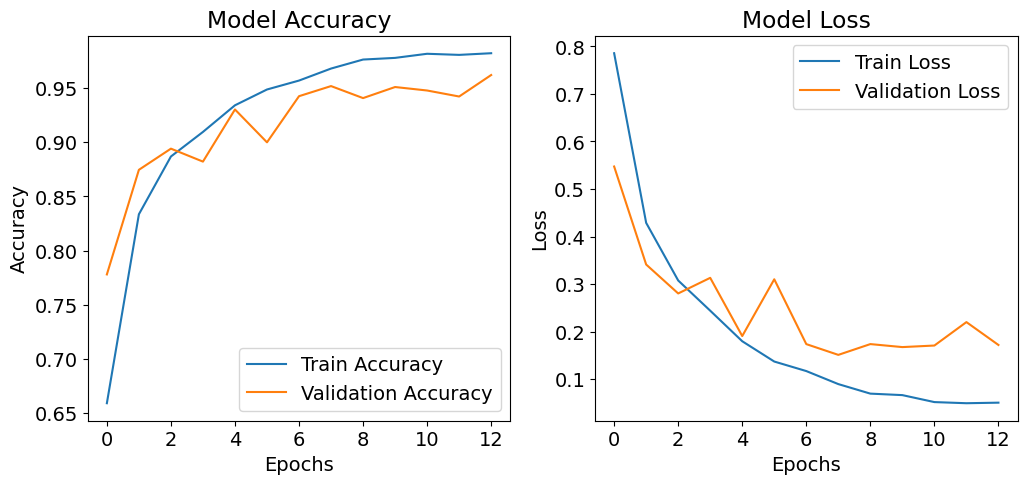

In [46]:

# Plot Accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Model Accuracy')

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Model Loss')

plt.show()

In [47]:
test_loss, test_acc = vgg_model.evaluate(processed_test_images, test_labels_onehot)
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")

41/41 ━━━━━━━━━━━━━━━━━━━━ 8s 102ms/step - accuracy: 0.9800 - loss: 0.0550
Test Accuracy: 0.9550
Test Loss: 0.1290


In [48]:
# Predict on test data
y_pred_probs = vgg_model.predict(processed_test_images)
y_pred_classes = np.argmax(y_pred_probs, axis=1)
y_true_classes = np.argmax(test_labels_onehot, axis=1)

41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step


[[268  25   3   4]
 [  5 283  13   5]
 [  0   0 405   0]
 [  0   4   0 296]]


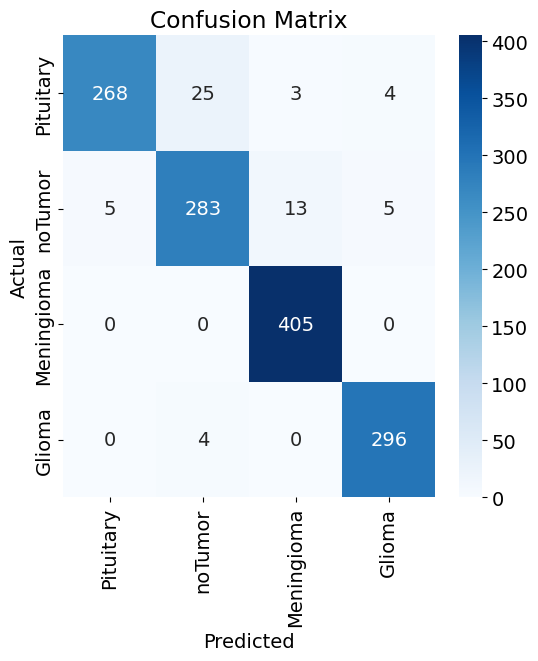

In [49]:

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
print(conf_matrix)
# Plot confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, cmap="Blues", xticklabels=class_names, yticklabels=class_names, fmt="d")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [50]:

# Print classification report
print(classification_report(y_true_classes, y_pred_classes, target_names=class_names))

              precision    recall  f1-score   support

   Pituitary       0.98      0.89      0.94       300
     noTumor       0.91      0.92      0.92       306
  Meningioma       0.96      1.00      0.98       405
      Glioma       0.97      0.99      0.98       300

    accuracy                           0.95      1311
   macro avg       0.96      0.95      0.95      1311
weighted avg       0.96      0.95      0.95      1311



1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 901ms/step

Class Mapping Table:
 Class Index Class Name
           0     glioma
           1 meningioma
           2    notumor
           3  pituitary

Prediction Results:
Actual Label: notumor (Index: 2)
Predicted Label: notumor (Index: 2, Confidence: 100.00%)


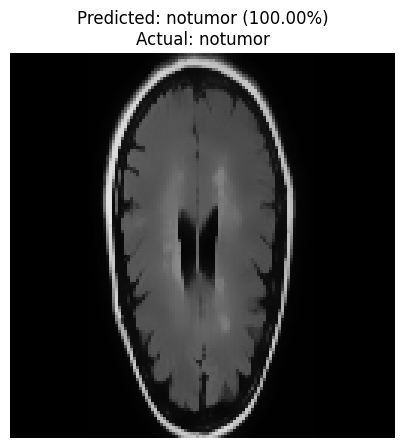

In [51]:

# Define class labels mapping
class_names = ["glioma", "meningioma", "notumor", "pituitary"]

# Select a sample image from the test set
sample_image = test_images[400]  # Pick an image
sample_label = test_labels[400]  # Actual label (likely a string)

sample_image = np.array(sample_image) / 255.0
# Expand dimensions (CNN expects batch format)
sample_image_expanded = np.expand_dims(sample_image, axis=0)

# Predict class probabilities
prediction =vgg_model.predict(sample_image_expanded)
predicted_class = np.argmax(prediction)  # Get class index
confidence = np.max(prediction) * 100   # Convert to percentage

# Create a table for class mapping
class_mapping_table = pd.DataFrame({
    "Class Index": [0, 1, 2, 3],
    "Class Name": class_names
})

# Convert string label to index
actual_class_index = class_names.index(sample_label)  # Get index from class_names list
predicted_label_name = class_names[predicted_class]  # Get predicted class name

# Print class mapping table
print("\nClass Mapping Table:")
print(class_mapping_table.to_string(index=False))

# Print results
print("\nPrediction Results:")
print(f"Actual Label: {sample_label} (Index: {actual_class_index})")
print(f"Predicted Label: {predicted_label_name} (Index: {predicted_class}, Confidence: {confidence:.2f}%)")

# Display Image with Prediction
plt.figure(figsize=(5, 5))
plt.imshow(sample_image, cmap='gray')
plt.title(f"Predicted: {predicted_label_name} ({confidence:.2f}%)\nActual: {sample_label}", fontsize=12)
plt.axis('off')
plt.show()


In [53]:
vgg_model.save("myvgg_model.keras")
print("Model saved successfully!")

Model saved successfully!


# DenseNet-121 Model

In [56]:

def conv_block(x, growth_rate, name):
    x1 = layers.BatchNormalization(name=name+'_bn1')(x)
    x1 = layers.Activation('relu', name=name+'_relu1')(x1)
    x1 = layers.Conv2D(4 * growth_rate, (1, 1), padding='same', name=name+'_conv1')(x1)

    x1 = layers.BatchNormalization(name=name+'_bn2')(x1)
    x1 = layers.Activation('relu', name=name+'_relu2')(x1)
    x1 = layers.Conv2D(growth_rate, (3, 3), padding='same', name=name+'_conv2')(x1)

    x = layers.Concatenate(name=name+'_concat')([x, x1])
    return x

def dense_block(x, num_blocks, growth_rate, name):
    for i in range(num_blocks):
        x = conv_block(x, growth_rate, name=f'{name}_block{i+1}')
    return x

def transition_layer(x, reduction, name):
    x = layers.BatchNormalization(name=name+'_bn')(x)
    x = layers.Activation('relu', name=name+'_relu')(x)
    x = layers.Conv2D(int(x.shape[-1] * reduction), (1, 1), padding='same', name=name+'_conv')(x)
    x = layers.AveragePooling2D((2, 2), strides=2, name=name+'_pool')(x)
    return x

def DenseNet121(input_shape=(128, 128, 3), num_classes=4):
    inputs = Input(shape=input_shape, name='input')
    
    # Initial conv and max-pooling
    x = layers.Conv2D(64, (7, 7), strides=2, padding='same', name='conv1')(inputs)
    x = layers.BatchNormalization(name='bn_conv1')(x)
    x = layers.Activation('relu', name='relu_conv1')(x)
    x = layers.MaxPooling2D((3, 3), strides=2, padding='same', name='pool1')(x)

    # Dense Block 1
    x = dense_block(x, num_blocks=6, growth_rate=32, name='dense1')
    x = transition_layer(x, reduction=0.5, name='trans1')

    # Dense Block 2
    x = dense_block(x, num_blocks=12, growth_rate=32, name='dense2')
    x = transition_layer(x, reduction=0.5, name='trans2')

    # Dense Block 3
    x = dense_block(x, num_blocks=24, growth_rate=32, name='dense3')
    x = transition_layer(x, reduction=0.5, name='trans3')

    # Dense Block 4
    x = dense_block(x, num_blocks=16, growth_rate=32, name='dense4')

    # Global Average Pooling and Output
    x = layers.BatchNormalization(name='bn_final')(x)
    x = layers.Activation('relu', name='relu_final')(x)
    x = layers.GlobalAveragePooling2D(name='avg_pool')(x)
    outputs = layers.Dense(num_classes, activation='softmax', name='fc')(x)

    model = Model(inputs, outputs, name='MYDenseNet121')
    return model

# Create the model
mydensenet_model = DenseNet121(input_shape=(128, 128, 3), num_classes=4)
mydensenet_model.summary()


Model: "MYDenseNet121"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)        │ (None, 128, 128, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1 (Conv2D)            │ (None, 64, 64, 64)     │          9,472 │ input[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_conv1                  │ (None, 64, 64, 64)     │            256 │ conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ relu_conv1 (Activation)   │ (None, 64, 64, 64)     │              0 │ bn_conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1 (MaxPooling2D)      │ (None, 32, 32, 64)     │              0 │ relu_conv1[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense1_block1_bn1         │ (None, 32, 32, 64)     │            256 │ pool1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense1_block1_relu1       │ (None, 32, 32, 64)     │              0 │ dense1_block1_bn1[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense1_block1_conv1       │ (None, 32, 32, 128)    │          8,320 │ dense1_block1_relu1[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense1_block1_bn2         │ (None, 32, 32, 128)    │            512 │ dense1_block1_conv1[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense1_block1_relu2       │ (None, 32, 32, 128)    │              0 │ dense1_block1_bn2[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense1_block1_conv2       │ (None, 32, 32, 32)     │         36,896 │ dense1_block1_relu2[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense1_block1_concat      │ (None, 32, 32, 96)     │              0 │ pool1[0][0],           │
│ (Concatenate)             │                        │                │ dense1_block1_conv2[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense1_block2_bn1         │ (None, 32, 32, 96)     │            384 │ dense1_block1_concat[… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense1_block2_relu1       │ (None, 32, 32, 96)     │              0 │ dense1_block2_bn1[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense1_block2_conv1  

 Total params: 7,051,844 (26.90 MB)

 Trainable params: 6,968,196 (26.58 MB)

 Non-trainable params: 83,648 (326.75 KB)

In [57]:
# Compile the model
mydensenet_model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [58]:
# Callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
]

In [59]:

# Train the model
history = mydensenet_model.fit(
    X_train, y_train,
    batch_size=16,
    epochs=15,
    validation_data=(X_val, y_val),
    callbacks=callbacks
)


Epoch 1/15
857/857 ━━━━━━━━━━━━━━━━━━━━ 281s 168ms/step - accuracy: 0.7530 - loss: 0.6376 - val_accuracy: 0.6911 - val_loss: 1.0599
Epoch 2/15
857/857 ━━━━━━━━━━━━━━━━━━━━ 58s 68ms/step - accuracy: 0.8908 - loss: 0.3025 - val_accuracy: 0.8226 - val_loss: 0.4309
Epoch 3/15
857/857 ━━━━━━━━━━━━━━━━━━━━ 58s 67ms/step - accuracy: 0.9259 - loss: 0.2058 - val_accuracy: 0.8999 - val_loss: 0.2802
Epoch 4/15
857/857 ━━━━━━━━━━━━━━━━━━━━ 57s 67ms/step - accuracy: 0.9536 - loss: 0.1377 - val_accuracy: 0.9294 - val_loss: 0.2026
Epoch 5/15
857/857 ━━━━━━━━━━━━━━━━━━━━ 57s 67ms/step - accuracy: 0.9623 - loss: 0.1098 - val_accuracy: 0.7474 - val_loss: 0.7772
Epoch 6/15
857/857 ━━━━━━━━━━━━━━━━━━━━ 58s 68ms/step - accuracy: 0.9726 - loss: 0.0812 - val_accuracy: 0.9446 - val_loss: 0.1453
Epoch 7/15
857/857 ━━━━━━━━━━━━━━━━━━━━ 58s 68ms/step - accuracy: 0.9779 - loss: 0.0690 - val_accuracy: 0.9641 - val_loss: 0.1115
Epoch 8/15
857/857 ━━━━━━━━━━━━━━━━━━━━ 57s 67ms/step - accuracy: 0.9805 - loss: 0.0601 

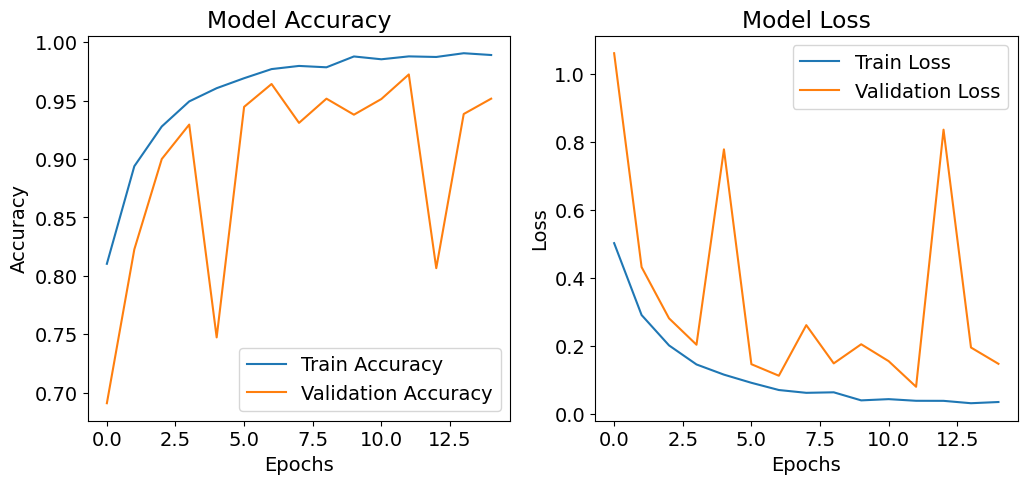

In [60]:

# Plot Accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Model Accuracy')

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Model Loss')

plt.show()

In [61]:
test_loss, test_acc = mydensenet_model.evaluate(processed_test_images, test_labels_onehot)
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")

41/41 ━━━━━━━━━━━━━━━━━━━━ 13s 179ms/step - accuracy: 0.9821 - loss: 0.0674
Test Accuracy: 0.9687
Test Loss: 0.0894


In [62]:
# Predict on test data
y_pred_probs = mydensenet_model.predict(processed_test_images)
y_pred_classes = np.argmax(y_pred_probs, axis=1)
y_true_classes = np.argmax(test_labels_onehot, axis=1)

41/41 ━━━━━━━━━━━━━━━━━━━━ 15s 195ms/step


[[280  16   0   4]
 [  3 291  11   1]
 [  1   1 403   0]
 [  0   4   0 296]]


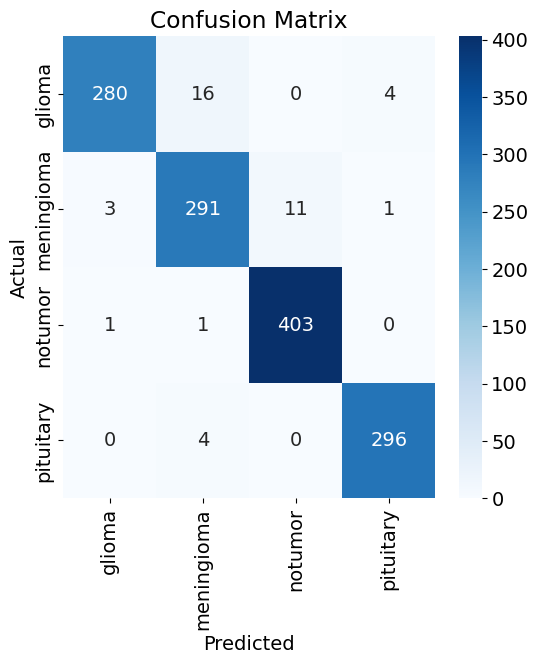

In [63]:

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
print(conf_matrix)
# Plot confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, cmap="Blues", xticklabels=class_names, yticklabels=class_names, fmt="d")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [64]:

# Print classification report
print(classification_report(y_true_classes, y_pred_classes, target_names=class_names))

              precision    recall  f1-score   support

      glioma       0.99      0.93      0.96       300
  meningioma       0.93      0.95      0.94       306
     notumor       0.97      1.00      0.98       405
   pituitary       0.98      0.99      0.99       300

    accuracy                           0.97      1311
   macro avg       0.97      0.97      0.97      1311
weighted avg       0.97      0.97      0.97      1311



In [65]:
mydensenet_model.save("mydensenet_model.keras")
print("Model saved successfully!")

Model saved successfully!


# InceptionNet-v1 Model

In [68]:

def inception_module(x, f1, f3r, f3, f5r, f5, proj, name=None):
    conv1 = layers.Conv2D(f1, (1,1), padding='same', activation='relu')(x)

    conv3 = layers.Conv2D(f3r, (1,1), padding='same', activation='relu')(x)
    conv3 = layers.Conv2D(f3, (3,3), padding='same', activation='relu')(conv3)

    conv5 = layers.Conv2D(f5r, (1,1), padding='same', activation='relu')(x)
    conv5 = layers.Conv2D(f5, (5,5), padding='same', activation='relu')(conv5)

    pool = layers.MaxPooling2D((3,3), strides=(1,1), padding='same')(x)
    pool = layers.Conv2D(proj, (1,1), padding='same', activation='relu')(pool)

    output = layers.concatenate([conv1, conv3, conv5, pool], axis=-1, name=name)
    return output

def GoogLeNet(input_shape=(128, 128, 3), num_classes=4):
    input_layer = Input(shape=input_shape)

    # Stem
    x = layers.Conv2D(64, (7,7), strides=2, padding='same', activation='relu')(input_layer)
    x = layers.MaxPooling2D((3,3), strides=2, padding='same')(x)
    x = layers.Conv2D(64, (1,1), padding='same', activation='relu')(x)
    x = layers.Conv2D(192, (3,3), padding='same', activation='relu')(x)
    x = layers.MaxPooling2D((3,3), strides=2, padding='same')(x)

    # Inception Blocks
    x = inception_module(x, 64, 96, 128, 16, 32, 32, name='inception_3a')
    x = inception_module(x, 128, 128, 192, 32, 96, 64, name='inception_3b')
    x = layers.MaxPooling2D((3,3), strides=2, padding='same')(x)

    x = inception_module(x, 192, 96, 208, 16, 48, 64, name='inception_4a')
    x = inception_module(x, 160, 112, 224, 24, 64, 64, name='inception_4b')
    x = inception_module(x, 128, 128, 256, 24, 64, 64, name='inception_4c')
    x = inception_module(x, 112, 144, 288, 32, 64, 64, name='inception_4d')
    x = inception_module(x, 256, 160, 320, 32, 128, 128, name='inception_4e')
    x = layers.MaxPooling2D((3,3), strides=2, padding='same')(x)

    x = inception_module(x, 256, 160, 320, 32, 128, 128, name='inception_5a')
    x = inception_module(x, 384, 192, 384, 48, 128, 128, name='inception_5b')

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.4)(x)
    output_layer = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(input_layer, output_layer, name='MyGoogLeNet')
    return model

# Create the model
myGoogLeNet_model = GoogLeNet(input_shape=(128, 128, 3), num_classes=4)
myGoogLeNet_model.summary()

Model: "MyGoogLeNet"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5             │ (None, 128, 128, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_140 (Conv2D)       │ (None, 64, 64, 64)     │          9,472 │ input_layer_5[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_36          │ (None, 32, 32, 64)     │              0 │ conv2d_140[0][0]       │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_141 (Conv2D)       │ (None, 32, 32, 64)     │          4,160 │ max_pooling2d_36[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_142 (Conv2D)       │ (None, 32, 32, 192)    │        110,784 │ conv2d_141[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_37          │ (None, 16, 16, 192)    │              0 │ conv2d_142[0][0]       │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_144 (Conv2D)       │ (None, 16, 16, 96)     │         18,528 │ max_pooling2d_37[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_146 (Conv2D)       │ (None, 16, 16, 16)     │          3,088 │ max_pooling2d_37[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_38          │ (None, 16, 16, 192)    │              0 │ max_pooling2d_37[0][0] │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_143 (Conv2D)       │ (None, 16, 16, 64)     │         12,352 │ max_pooling2d_37[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_145 (Conv2D)       │ (None, 16, 16, 128)    │        110,720 │ conv2d_144[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_147 (Conv2D)       │ (None, 16, 16, 32)     │         12,832 │ conv2d_146[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_148 (Conv2D)       │ (None, 16, 16, 32)     │          6,176 │ max_pooling2d_38[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ inception_3a              │ (None, 16, 16, 256)    │              0 │ conv2d_143[0][0],      │
│ (Concatenate)             │                        │                │ conv2d_145[0][0],      │
│                           │                        │                │ conv2d_147[0][0],      │
│                           │                        │                │ conv2d_148[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_150 (Conv2D)       │ (None, 16, 16, 128)    │         32,896 │ inception_3a[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_152 (Conv2D)       │ (None, 16, 16, 32)     │          8,224 │ inception_3a[0][0]     │
├──────────────────────

 Total params: 5,977,652 (22.80 MB)

 Trainable params: 5,977,652 (22.80 MB)

 Non-trainable params: 0 (0.00 B)

In [69]:
# Compile the model
myGoogLeNet_model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [70]:
# Callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
]

In [71]:

# Train the model
history = myGoogLeNet_model.fit(
    X_train, y_train,
    batch_size=16, 
    epochs=15,
    validation_data=(X_val, y_val),
    callbacks=callbacks
)


Epoch 1/15
857/857 ━━━━━━━━━━━━━━━━━━━━ 74s 54ms/step - accuracy: 0.4713 - loss: 1.0916 - val_accuracy: 0.7663 - val_loss: 0.6073
Epoch 2/15
857/857 ━━━━━━━━━━━━━━━━━━━━ 22s 26ms/step - accuracy: 0.7840 - loss: 0.5498 - val_accuracy: 0.8366 - val_loss: 0.4477
Epoch 3/15
857/857 ━━━━━━━━━━━━━━━━━━━━ 22s 26ms/step - accuracy: 0.8558 - loss: 0.3807 - val_accuracy: 0.8836 - val_loss: 0.3431
Epoch 4/15
857/857 ━━━━━━━━━━━━━━━━━━━━ 22s 26ms/step - accuracy: 0.8990 - loss: 0.2714 - val_accuracy: 0.8585 - val_loss: 0.3464
Epoch 5/15
857/857 ━━━━━━━━━━━━━━━━━━━━ 22s 26ms/step - accuracy: 0.9255 - loss: 0.2106 - val_accuracy: 0.9355 - val_loss: 0.1749
Epoch 6/15
857/857 ━━━━━━━━━━━━━━━━━━━━ 22s 26ms/step - accuracy: 0.9399 - loss: 0.1644 - val_accuracy: 0.9014 - val_loss: 0.2888
Epoch 7/15
857/857 ━━━━━━━━━━━━━━━━━━━━ 22s 26ms/step - accuracy: 0.9533 - loss: 0.1238 - val_accuracy: 0.9288 - val_loss: 0.1933
Epoch 8/15
857/857 ━━━━━━━━━━━━━━━━━━━━ 22s 26ms/step - accuracy: 0.9622 - loss: 0.1145 - 

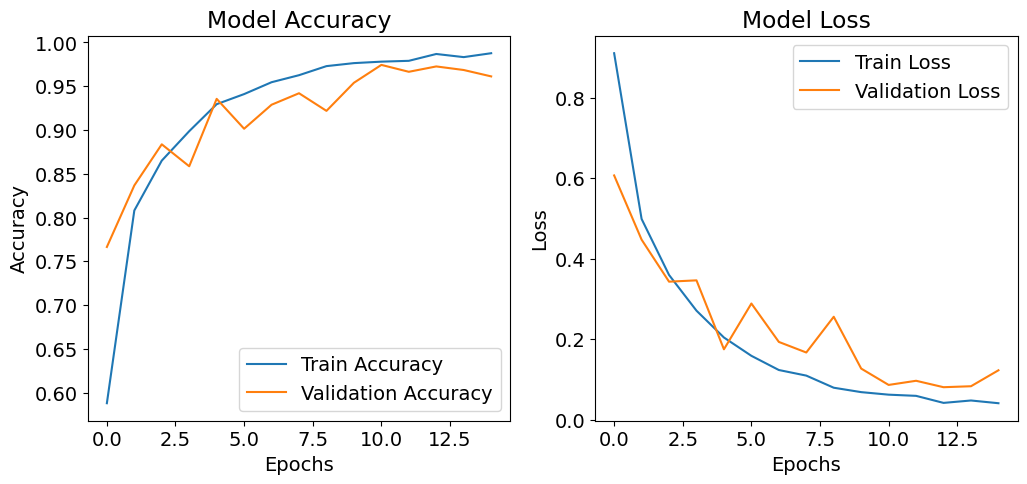

In [72]:

# Plot Accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Model Accuracy')

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Model Loss')

plt.show()

In [73]:
test_loss, test_acc = myGoogLeNet_model.evaluate(processed_test_images, test_labels_onehot)
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")

41/41 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - accuracy: 0.9849 - loss: 0.0374
Test Accuracy: 0.9710
Test Loss: 0.0833


In [74]:
# Predict on test data
y_pred_probs = myGoogLeNet_model.predict(processed_test_images)
y_pred_classes = np.argmax(y_pred_probs, axis=1)
y_true_classes = np.argmax(test_labels_onehot, axis=1)

41/41 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step


[[280  15   0   5]
 [  3 293   1   9]
 [  0   1 404   0]
 [  1   3   0 296]]


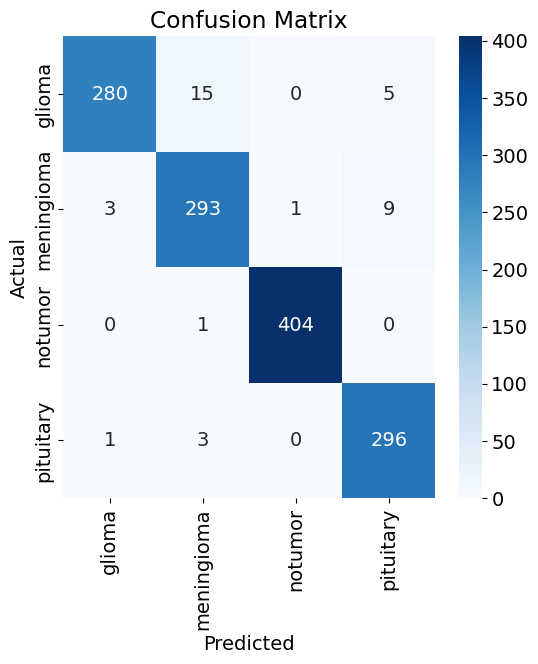

In [75]:

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
print(conf_matrix)
# Plot confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, cmap="Blues", xticklabels=class_names, yticklabels=class_names, fmt="d")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [76]:

# Print classification report
print(classification_report(y_true_classes, y_pred_classes, target_names=class_names))

              precision    recall  f1-score   support

      glioma       0.99      0.93      0.96       300
  meningioma       0.94      0.96      0.95       306
     notumor       1.00      1.00      1.00       405
   pituitary       0.95      0.99      0.97       300

    accuracy                           0.97      1311
   macro avg       0.97      0.97      0.97      1311
weighted avg       0.97      0.97      0.97      1311



In [77]:
myGoogLeNet_model.save("myGoogLeNet_model.keras")
print("Model saved successfully!")

Model saved successfully!


# Modified Model

In [15]:

# Inception-Dense Block with skip connection
def inception_dense_block(x, filters):
    shortcut = x  # Save for internal skip connection

    path1 = layers.Conv2D(filters, (1, 1), padding='same')(x)
    path1 = layers.BatchNormalization()(path1)
    path1 = layers.ReLU()(path1)

    path2 = layers.Conv2D(filters, (3, 3), padding='same')(x)
    path2 = layers.BatchNormalization()(path2)
    path2 = layers.ReLU()(path2)

    path3 = layers.Conv2D(filters, (5, 5), padding='same')(x)
    path3 = layers.BatchNormalization()(path3)
    path3 = layers.ReLU()(path3)

    path4 = layers.MaxPooling2D((3, 3), strides=(1, 1), padding='same')(x)
    path4 = layers.Conv2D(filters, (1, 1), padding='same')(path4)
    path4 = layers.BatchNormalization()(path4)
    path4 = layers.ReLU()(path4)

    out = layers.Concatenate()([path1, path2, path3, path4])

    # Internal Skip Connection
    if shortcut.shape[-1] != out.shape[-1]:
        shortcut = layers.Conv2D(out.shape[-1], (1, 1), padding='same')(shortcut)
        shortcut = layers.BatchNormalization()(shortcut)

    out = layers.Add()([out, shortcut])
    out = layers.ReLU()(out)

    return out

# Dense Block
def dense_block(x, num_layers, growth_rate):
    for _ in range(num_layers):
        out = inception_dense_block(x, growth_rate)
        x = layers.Concatenate()([x, out])
    return x

# Transition Layer
def transition_layer(x, reduction, name):
    x = layers.BatchNormalization(name=name+'_bn')(x)
    x = layers.Activation('relu', name=name+'_relu')(x)
    x = layers.Conv2D(int(x.shape[-1] * reduction), (1, 1), padding='same', name=name+'_conv')(x)
    x = layers.AveragePooling2D((2, 2), strides=2, name=name+'_pool')(x)
    return x

# Modified Model
def Modified_Model(input_shape=(128,128,3), num_classes=4):
    inputs = layers.Input(shape=input_shape)

    # Initial Conv
    x = layers.Conv2D(64, (7,7), strides=2, padding='same', name='conv1')(inputs)
    x = layers.BatchNormalization(name='bn_conv1')(x)
    x = layers.Activation('relu', name='relu_conv1')(x)
    x = layers.MaxPooling2D((3,3), strides=2, padding='same', name='pool1')(x)

    # Save for skip1
    skip1 = x

    # Dense Block 1
    x = dense_block(x, num_layers=3, growth_rate=32)
    x = transition_layer(x, reduction=0.5, name='trans1')

    # Downsample skip1 to match x
    skip1 = layers.MaxPooling2D(pool_size=(2,2), strides=2, padding='same')(skip1)

    # Add skip1
    x = layers.Concatenate()([x, skip1])

    # Save for skip2
    skip2 = x

    # Dense Block 2
    x = dense_block(x, num_layers=6, growth_rate=32)
    x = transition_layer(x, reduction=0.5, name='trans2')

    # Downsample skip2 to match x
    skip2 = layers.MaxPooling2D(pool_size=(2,2), strides=2, padding='same')(skip2)

    # Add skip2
    x = layers.Concatenate()([x, skip2])

    # Save for skip3
    skip3 = x

    # Dense Block 3
    x = dense_block(x, num_layers=12, growth_rate=32)
    x = transition_layer(x, reduction=0.5, name='trans3')

    # Downsample skip3 to match x
    skip3 = layers.MaxPooling2D(pool_size=(2,2), strides=2, padding='same')(skip3)

    # Add skip3
    x = layers.Concatenate()([x, skip3])

    # Dense Block 4
    x = dense_block(x, num_layers=8, growth_rate=32)

    # Final Layers
    x = layers.BatchNormalization(name='bn_final')(x)
    x = layers.Activation('relu', name='relu_final')(x)
    x = layers.GlobalAveragePooling2D(name='avg_pool')(x)
    x = layers.Dense(4096, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(4096, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation='softmax', name='fc')(x)

    model = models.Model(inputs, outputs, name='Modified_Model')
    return model

# Instantiate and summarize
Modified_Model = Modified_Model(input_shape=(128, 128, 3), num_classes=4)
Modified_Model.summary()


Model: "Modified_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 128, 128, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1 (Conv2D)            │ (None, 64, 64, 64)     │          9,472 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_conv1                  │ (None, 64, 64, 64)     │            256 │ conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ relu_conv1 (Activation)   │ (None, 64, 64, 64)     │              0 │ bn_conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1 (MaxPooling2D)      │ (None, 32, 32, 64)     │              0 │ relu_conv1[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 32, 32, 64)     │              0 │ pool1[0][0]            │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 32, 32, 32)     │          2,080 │ pool1[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 32, 32, 32)     │         18,464 │ pool1[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 32, 32, 32)     │         51,232 │ pool1[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 32, 32, 32)     │          2,080 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 32, 32, 32)     │            128 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 32, 32, 32)     │            128 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 32, 32, 32)     │            128 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 32, 32, 32)     │            128 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu (ReLU)              │ (None, 32, 32, 32)     │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_1 (ReLU)            │ (None, 32, 32, 32)     │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_2 (ReLU)       

 Total params: 86,394,988 (329.57 MB)

 Trainable params: 86,366,268 (329.46 MB)

 Non-trainable params: 28,720 (112.19 KB)

In [16]:
# Compile the model
Modified_Model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [17]:
# Callbacks

callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
]


In [18]:
history = Modified_Model.fit(
    X_train, y_train,
    batch_size=16,
    epochs=10,
    validation_data=(X_val, y_val),
    callbacks=callbacks
)

Epoch 1/10
857/857 ━━━━━━━━━━━━━━━━━━━━ 522s 400ms/step - accuracy: 0.7078 - loss: 0.8125 - val_accuracy: 0.7914 - val_loss: 0.7160
Epoch 2/10
857/857 ━━━━━━━━━━━━━━━━━━━━ 214s 250ms/step - accuracy: 0.8746 - loss: 0.3566 - val_accuracy: 0.5837 - val_loss: 1.6290
Epoch 3/10
857/857 ━━━━━━━━━━━━━━━━━━━━ 214s 250ms/step - accuracy: 0.9273 - loss: 0.2118 - val_accuracy: 0.9075 - val_loss: 0.2290
Epoch 4/10
857/857 ━━━━━━━━━━━━━━━━━━━━ 214s 250ms/step - accuracy: 0.9483 - loss: 0.1532 - val_accuracy: 0.8891 - val_loss: 0.2702
Epoch 5/10
857/857 ━━━━━━━━━━━━━━━━━━━━ 214s 250ms/step - accuracy: 0.9603 - loss: 0.1140 - val_accuracy: 0.9347 - val_loss: 0.2094
Epoch 6/10
857/857 ━━━━━━━━━━━━━━━━━━━━ 214s 250ms/step - accuracy: 0.9666 - loss: 0.1149 - val_accuracy: 0.9186 - val_loss: 0.2348
Epoch 7/10
857/857 ━━━━━━━━━━━━━━━━━━━━ 214s 250ms/step - accuracy: 0.9706 - loss: 0.0957 - val_accuracy: 0.8428 - val_loss: 0.7925
Epoch 8/10
857/857 ━━━━━━━━━━━━━━━━━━━━ 214s 249ms/step - accuracy: 0.9737 -

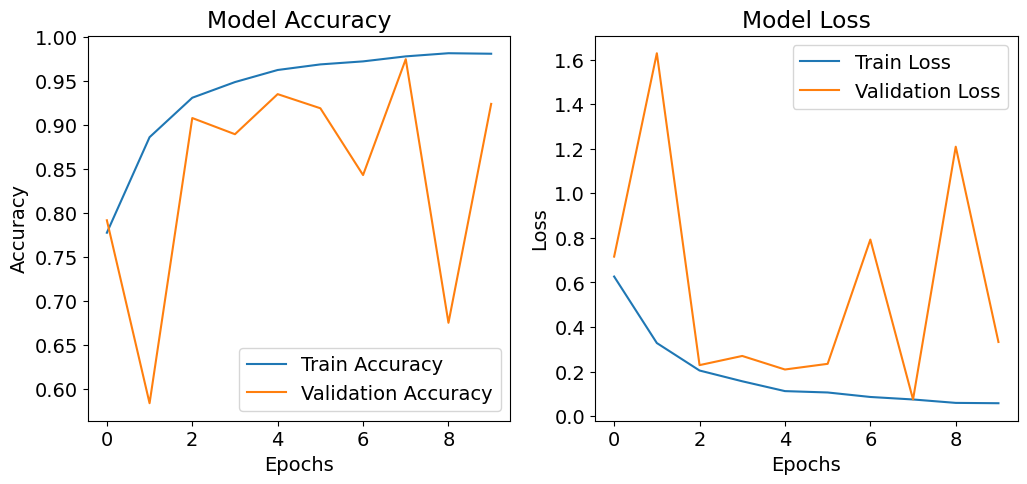

In [19]:

# Plot Accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Model Accuracy')

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Model Loss')

plt.show()

In [20]:
test_loss, test_acc = Modified_Model.evaluate(processed_test_images, test_labels_onehot)
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")

41/41 ━━━━━━━━━━━━━━━━━━━━ 44s 612ms/step - accuracy: 0.9827 - loss: 0.0533
Test Accuracy: 0.9786
Test Loss: 0.0620


In [21]:
# Predict on test data
y_pred_probs = Modified_Model.predict(processed_test_images)
y_pred_classes = np.argmax(y_pred_probs, axis=1)
y_true_classes = np.argmax(test_labels_onehot, axis=1)

41/41 ━━━━━━━━━━━━━━━━━━━━ 30s 437ms/step


[[291   9   0   0]
 [  2 293   5   6]
 [  0   2 403   0]
 [  2   2   0 296]]


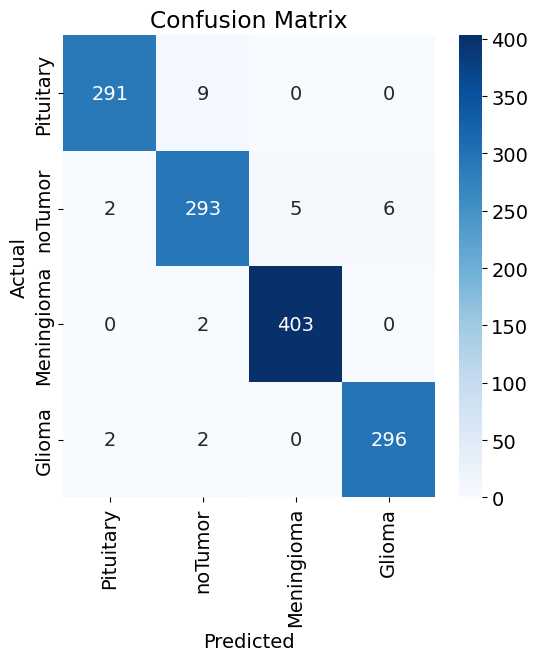

In [22]:

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
print(conf_matrix)
# Plot confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, cmap="Blues", xticklabels=class_names, yticklabels=class_names, fmt="d")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [23]:

# Print classification report
print(classification_report(y_true_classes, y_pred_classes, target_names=class_names))

              precision    recall  f1-score   support

   Pituitary       0.99      0.97      0.98       300
     noTumor       0.96      0.96      0.96       306
  Meningioma       0.99      1.00      0.99       405
      Glioma       0.98      0.99      0.98       300

    accuracy                           0.98      1311
   macro avg       0.98      0.98      0.98      1311
weighted avg       0.98      0.98      0.98      1311



In [24]:

def sensitivity_specificity_per_class(conf_matrix):
    for i in range(len(conf_matrix)):
        tp = conf_matrix[i, i]
        fn = np.sum(conf_matrix[i, :]) - tp
        fp = np.sum(conf_matrix[:, i]) - tp
        tn = np.sum(conf_matrix) - (tp + fp + fn)

        sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

        print(f"Class {i}: Sensitivity (Recall) = {sensitivity:.4f}, Specificity = {specificity:.4f}")


In [25]:

cm = confusion_matrix(y_true_classes, y_pred_classes)
sensitivity_specificity_per_class(cm)


Class 0: Sensitivity (Recall) = 0.9700, Specificity = 0.9960
Class 1: Sensitivity (Recall) = 0.9575, Specificity = 0.9871
Class 2: Sensitivity (Recall) = 0.9951, Specificity = 0.9945
Class 3: Sensitivity (Recall) = 0.9867, Specificity = 0.9941


In [26]:

mcc = matthews_corrcoef(y_true_classes, y_pred_classes)
print(f"MCC: {mcc:.4f}")


MCC: 0.9714


In [27]:
Modified_Model.save("Modified_Model.keras")
print("Model saved successfully!")

Model saved successfully!


# Model Evaluation

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 34 variables whereas the saved optimizer has 66 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step


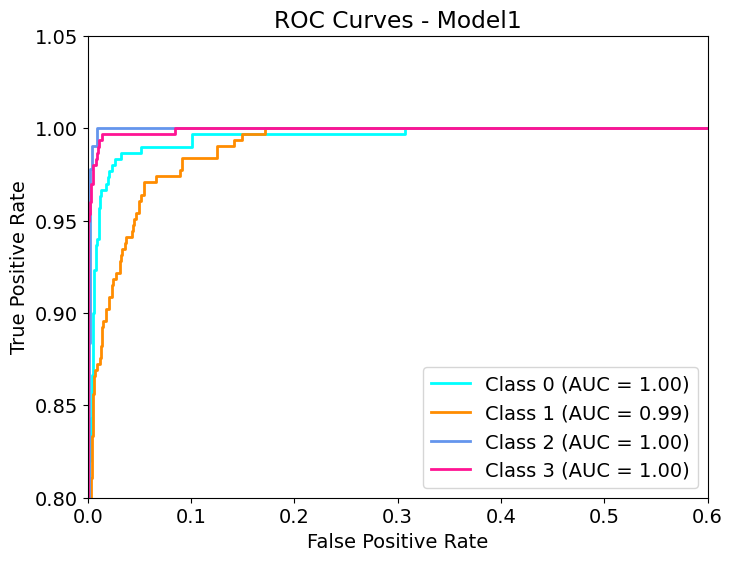

41/41 ━━━━━━━━━━━━━━━━━━━━ 13s 173ms/step


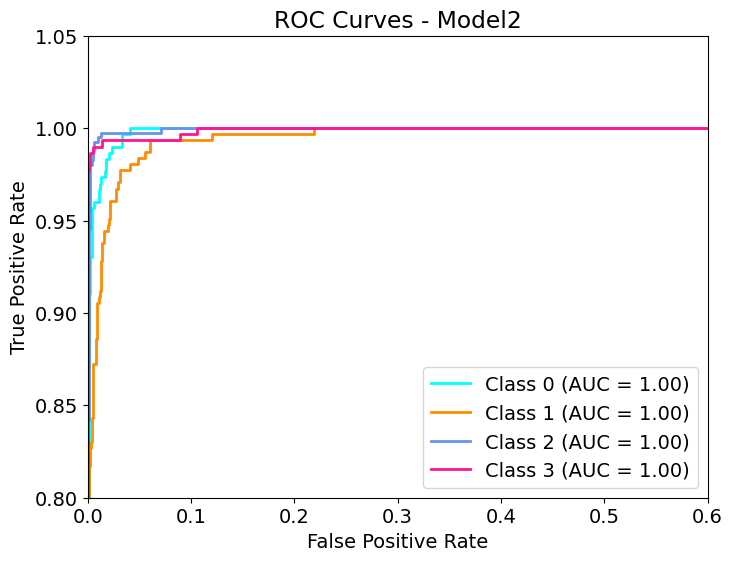

41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step


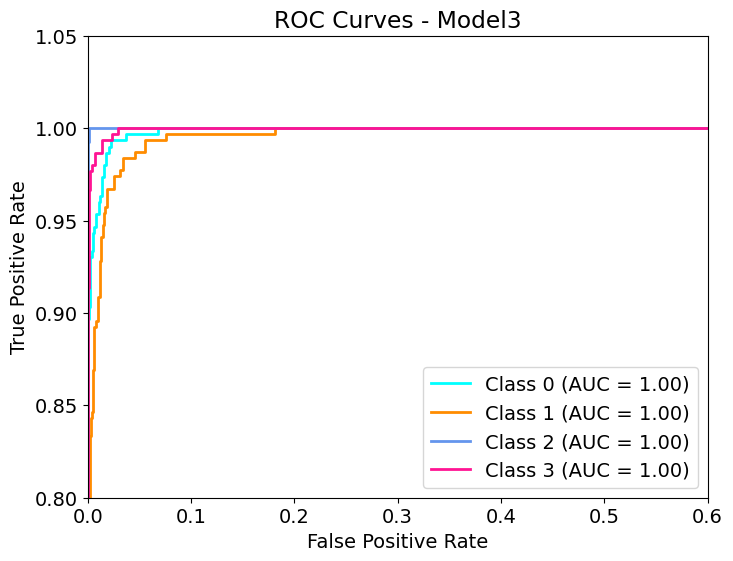

41/41 ━━━━━━━━━━━━━━━━━━━━ 27s 413ms/step


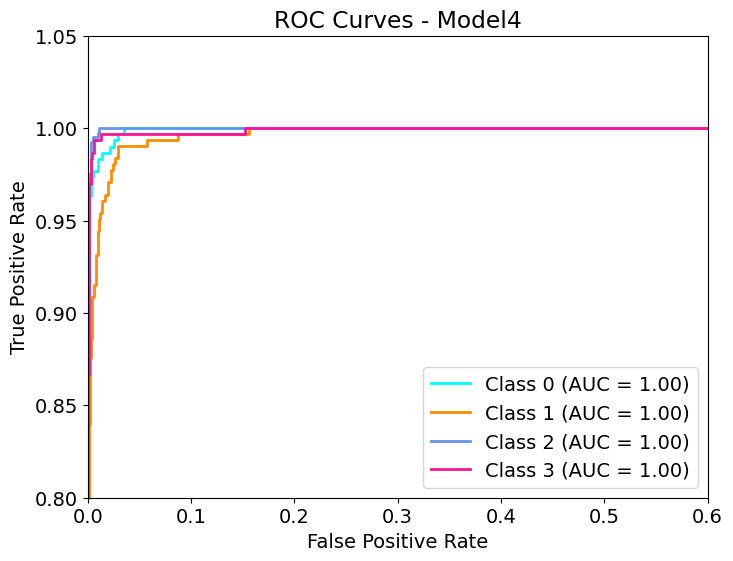

Performance Comparison:
          MCC  Avg Sensitivity  Avg Specificity  ROC AUC (macro)
Model                                                           
Model1  0.940            0.951            0.985            0.997
Model2  0.958            0.967            0.990            0.998
Model3  0.961            0.969            0.991            0.999
Model4  0.971            0.977            0.993            0.999


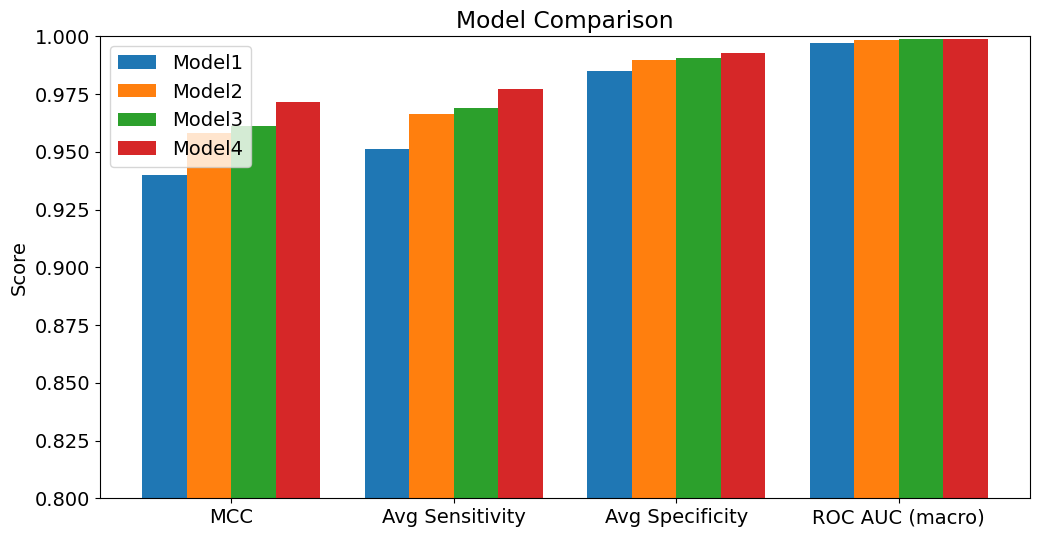

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import (
    confusion_matrix,
    roc_curve,
    auc,
    matthews_corrcoef,
    roc_auc_score
)
from tensorflow.keras.models import load_model
from itertools import cycle

# =================================================================
# Load Models and Data
# =================================================================
model_paths = {
    'Model1': '/kaggle/input/model/keras/default/3/myvgg_model.keras',
    'Model2': '/kaggle/input/model/keras/default/3/mydensenet_model.keras',
    'Model3': '/kaggle/input/model/keras/default/3/myGoogLeNet_model.keras',
    'Model4': '/kaggle/input/model/keras/default/3/Modified_Model.keras'
}

models = {name: load_model(path) for name, path in model_paths.items()}

# =================================================================
# Metrics Calculation
# =================================================================
results = []
n_classes = test_labels_onehot.shape[1]
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'deeppink'])

for model_name, model in models.items():
    # Predict probabilities and classes
    y_pred_proba = model.predict(processed_test_images)
    y_pred = np.argmax(y_pred_proba, axis=1)
    y_true = np.argmax(test_labels_onehot, axis=1)
    
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Calculate class-wise metrics
    sensitivity = []
    specificity = []
    for i in range(n_classes):
        tp = cm[i, i]
        fn = cm[i, :].sum() - tp
        fp = cm[:, i].sum() - tp
        tn = cm.sum() - (tp + fn + fp)
        
        sensitivity.append(tp / (tp + fn + 1e-9))
        specificity.append(tn / (tn + fp + 1e-9))
    
    # Aggregate metrics
    metrics = {
        'Model': model_name,
        'MCC': matthews_corrcoef(y_true, y_pred),
        'Avg Sensitivity': np.mean(sensitivity),
        'Avg Specificity': np.mean(specificity),
        'ROC AUC (macro)': roc_auc_score(test_labels_onehot, y_pred_proba, multi_class='ovr', average='macro')
    }
    results.append(metrics)
    
    # Plot ROC curves
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(test_labels_onehot[:, i], y_pred_proba[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    plt.figure(figsize=(8, 6))
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label=f'Class {i} (AUC = {roc_auc[i]:.2f})')
    
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 0.6])
    plt.ylim([0.8, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curves - {model_name}')
    plt.legend(loc="lower right")
    plt.show()

# =================================================================
# Results Summary
# =================================================================
results_df = pd.DataFrame(results).set_index('Model')
print("Performance Comparison:")
print(results_df.round(3))

# =================================================================
# Visualization of Key Metrics
# =================================================================
plt.figure(figsize=(12, 6))
metrics_to_plot = ['MCC', 'Avg Sensitivity', 'Avg Specificity', 'ROC AUC (macro)']
x = np.arange(len(metrics_to_plot))

for i, model_name in enumerate(models.keys()):
    values = [results_df.loc[model_name, metric] for metric in metrics_to_plot]
    plt.bar(x + i*0.2, values, width=0.2, label=model_name)

plt.xticks(x + 0.3, metrics_to_plot)
plt.ylabel('Score')
plt.title('Model Comparison')
plt.legend()
plt.ylim(0.8, 1)
plt.show()